# XGBoost Model

## Import Statements

In [1]:
import pandas as pd
import sklearn
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier, plot_importance, callback, XGBRFClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
import shap
pd.set_option('display.max_columns', None)

/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Import

In [2]:
df = pd.read_csv('data/preprocessed_data.csv')
df.head()
(df['Label'] == 1).sum() / (df['Label'] == 0).sum()

np.float64(4.99110510874121)

## Extract Features and Labels

In [3]:
X = df.drop(columns=['Label'])
y = df['Label']

## Train Val Test Split

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [5]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))
print(np.unique(y_test, return_counts=True))


(array([0, 1]), array([ 85892, 428696]))
(array([0, 1]), array([10736, 53587]))
(array([0, 1]), array([10737, 53587]))


## Format Object Types to Category Types

In [6]:
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')

for col in X_val.select_dtypes(include='object').columns:
    X_val[col] = X_val[col].astype('category')

for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].astype('category')

## Weighting

In [7]:
# from sklearn.utils import resample
# #import pandas as pd
# #
# #Combine features and labels if separate
# df = pd.concat([X_train, y_train], axis=1)
# #
# #Separate classes
# df_majority = df[df['Label'] == 1]
# df_minority = df[df['Label'] == 0]
# #
# #Downsample majority class
# df_majority_downsampled = resample(df_majority,
# replace=False,
# n_samples=len(df_minority),
# random_state=42)
# #
# #Combine and shuffle
# df_downsampled = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42)
# #
# #Split back to X and y
# X_train = df_downsampled.drop(columns='Label')
# y_train = df_downsampled['Label']

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy='auto')
X_train, y_train = smote.fit_resample(X_train, y_train)

In [8]:
pos_class_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)
# print(f"Positive class weight: {pos_class_weight}")

from sklearn.utils import compute_sample_weight

sample_weights = compute_sample_weight(class_weight={0: 1, 1: 1.1}, y=y_train)


## Model Training

In [9]:
# model = XGBClassifier(
#     enable_categorical=True,  # IMPORTANT
#     eval_metric='logloss',
#     objective='binary:logistic',
#     scale_pos_weight=pos_class_weight,
#     max_delta_step=1,  
#     n_jobs=-1, 
# )

In [10]:
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Define the model
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=pos_class_weight,
    enable_categorical=True,
    use_label_encoder=False,
    random_state=42
)

# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'reg_alpha': [0, 0.5, 1.0, 2.0],
    'reg_lambda': [0.5, 1.0, 2.0],
}

# Define stratified k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scorer
scorer = make_scorer(f1_score)

# Setup random search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=25,  # adjust this based on how long you're willing to wait
    scoring=scorer,
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train, 
                  eval_set=[(X_test, y_test)], 
                  #sample_weight = sample_weights, 
                  verbose=False)



# Best model
best_model = random_search.best_estimator_

# Best params
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:50:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:50:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:50:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:50:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hom

Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [11]:
# best_model.fit(
#     X_train, y_train,
#     #sample_weight = sample_weights,
#     eval_set=[(X_val, y_val)],
#     verbose=True,
# )

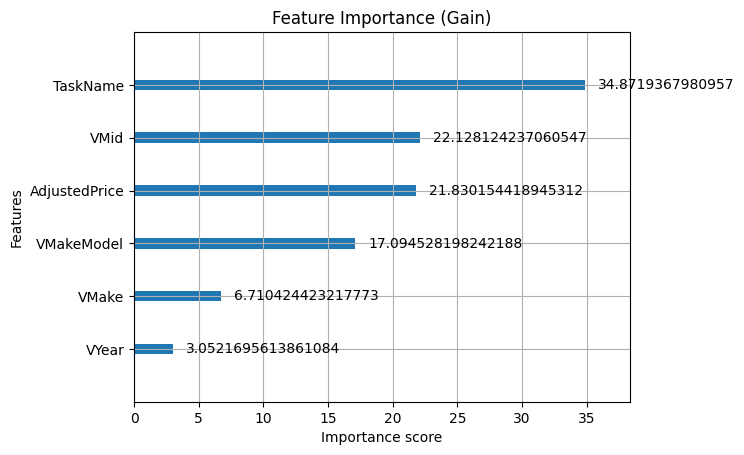

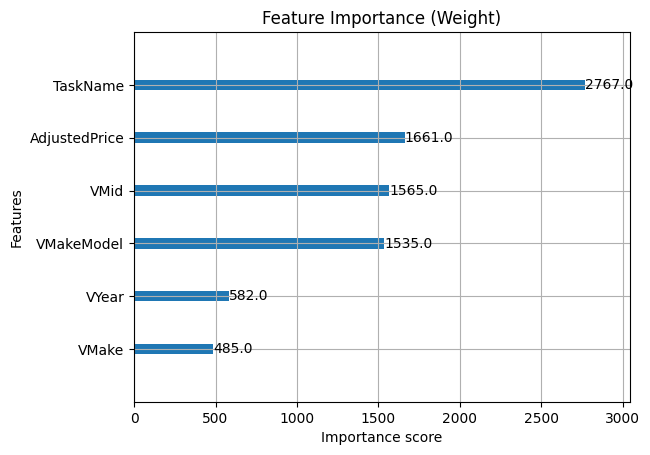

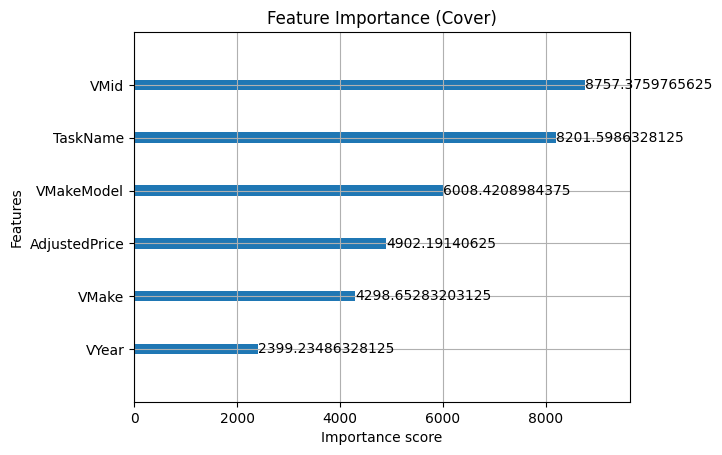

In [12]:
plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title('Feature Importance (Gain)')
plt.show()

# Weight importance plot
plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance (Weight)')
plt.show()

# Cover importance plot
plot_importance(best_model, importance_type='cover', max_num_features=10)
plt.title('Feature Importance (Cover)')
plt.show()

In [13]:
y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:, 1]  # For ROC/AUC

In [14]:
y_pred_train= best_model.predict(X_train)
y_proba_train = best_model.predict_proba(X_train)[:, 1]  # For ROC/AUC

In [ ]:
def evaluate_model(X_test, y_test, y_pred, y_proba):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [20]:
def evaluate_model_threshold(X_test, y_test, y_pred, y_proba, threshold):
    y_pred_class = y_proba > threshold
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_class, ax=ax)
    print("Accuracy:", accuracy_score(y_test, y_pred_class))
    print("Precision:", precision_score(y_test, y_pred_class))
    print("Recall:", recall_score(y_test, y_pred_class))
    print("F1 Score:", f1_score(y_test, y_pred_class))
    print("ROC AUC:", roc_auc_score(y_test, y_pred_class))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))

Accuracy: 0.7248944786897479
Precision: 0.906778076229982
Recall: 0.7465220109354881
F1 Score: 0.8188831515759415
ROC AUC: 0.6817356014720285
Confusion Matrix:
 [[ 52991  32901]
 [108665 320031]]


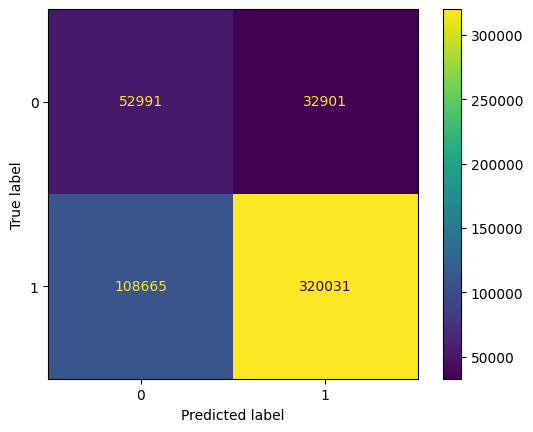

In [ ]:
evaluate_model(X_train, y_train, y_pred_train, y_proba_train)

Accuracy: 0.7297431751756731
Precision: 0.8521350063223422
Recall: 0.8174370649597851
F1 Score: 0.8344254800365742
ROC AUC: 0.5547556005622247
Confusion Matrix:
 [[ 3136  7601]
 [ 9783 43804]]


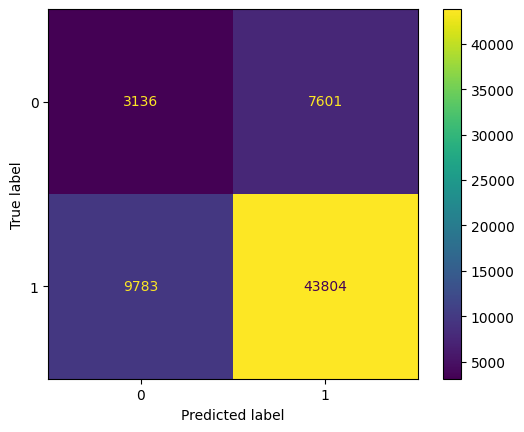

In [ ]:
evaluate_model(X_test, y_test, y_pred_test, y_proba_test)

Accuracy: 0.6405851626142652
Precision: 0.8605680473372781
Recall: 0.6785041148039637
F1 Score: 0.7587674906351409
ROC AUC: 0.5649203073786979
Confusion Matrix:
 [[ 4846  5891]
 [17228 36359]]


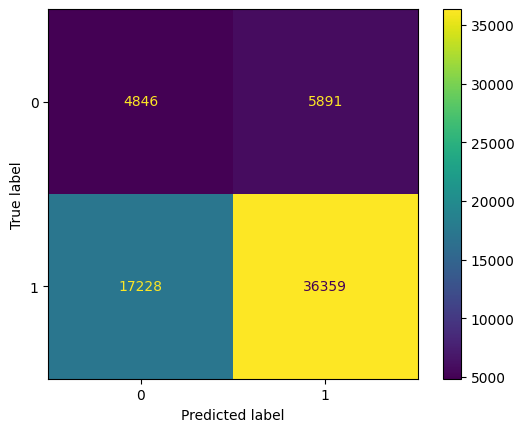

In [24]:
evaluate_model_threshold(X_test, y_test, y_pred_test, y_proba_test, threshold=0.57);

In [18]:
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

for col in X_train_enc.select_dtypes(['category']).columns:
    X_train_enc[col] = X_train_enc[col].cat.codes
    X_test_enc[col] = X_test_enc[col].cat.codes

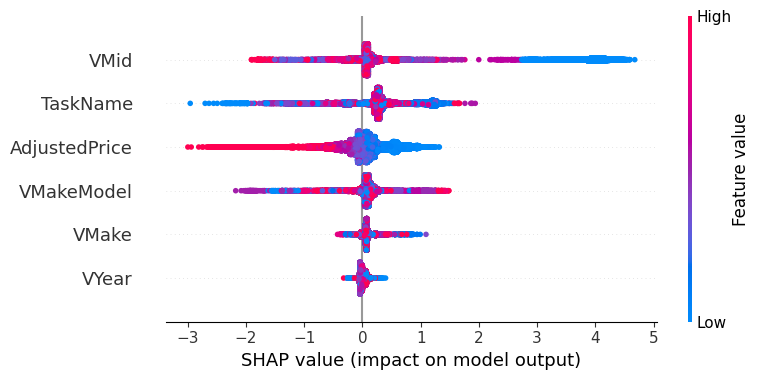

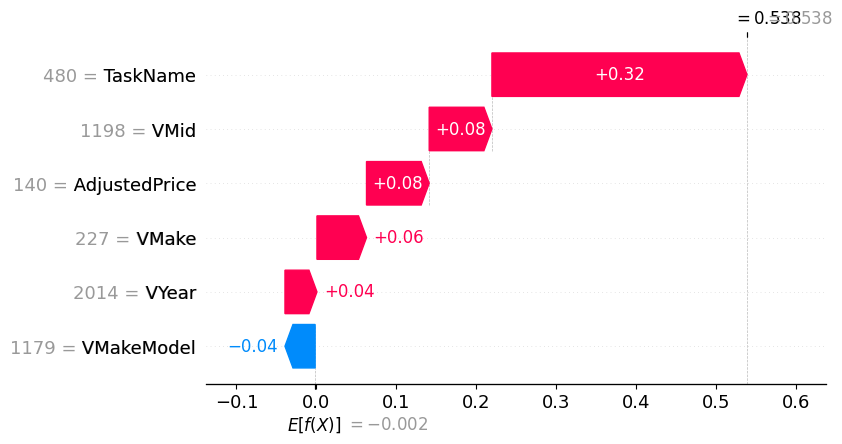

In [19]:
#best_model = search.best_estimator_
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test_enc)  # Note the parentheses instead of .shap_values()
shap.summary_plot(shap_values, X_test_enc)


# Individual prediction explanation
shap.plots.waterfall(shap_values[0])  # for the first sample